In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    Steps (Huang et al., 2006):
      1) Randomly assign input weights W1 and biases b for the hidden layer.
      2) Compute hidden layer output matrix H.
      3) Compute output weights beta = H^dagger * T (Moore-Penrose pseudoinverse).
    """
    def __init__(self, input_size, hidden_size, output_size, activation='relu', seed=None):
        """
        Parameters
        ----------
        input_size : int
            Number of input features (dimension of x).
        hidden_size : int
            Number of hidden neurons.
        output_size : int
            Number of output dimensions (dimension of t).
        activation : callable, optional
            Activation function g(z) to use.
            If None, defaults to ReLU.
        seed : int, optional
            Seed for reproducible random initialization.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        if seed:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            # no derivative provided => handle carefully or raise error
            self.activation_deriv = None
            print("Warning: no derivative for a custom activation. Backprop may fail.")

        # Randomly init input->hidden weights, not updated in ELM
        # For ReLU, a good approach is He initialization:
        # For Tanh, a good approach is Xavier (scaled uniform).
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights: We DO train these
        # We'll do a simple Xavier-like approach for either ReLU or Tanh:
        limit_out = np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Placeholders for forward pass
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ------------------------
    # Activation functions
    # ------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        # derivative wrt the pre-activation
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        # derivative wrt pre-activation for tanh
        # if we define y = tanh(x), derivative = 1 - y^2
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient
    def _l1_subgrad(self, w):
        # returns sign(w), with sign(0)=0
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ------------------------
    # Forward pass
    # ------------------------
    def forward(self, X):
        """
        Forward pass with either ReLU or tanh hidden activation,
        then a linear activation (or if you prefer, you could
        also do tanh at the output).
        """
        # hidden
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)

        # output
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        # We'll do linear output by default.
        # If you want tanh final, do: self.predicted_output = np.tanh(self.output_layer_input)
        self.predicted_output = self.output_layer_input

        return self.predicted_output

    # ------------------------
    # Backward pass
    # ------------------------
    def backward(self, X, y):
        """
        Compute gradients wrt the hidden->output weights
        for a MSE + L1 penalty on W2.

        Because we do not update input->hidden in an ELM
        (by definition it's random and fixed),
        we only compute partial derivatives wrt (W2, b2).
        """
        n_samples = X.shape[0]

        # 1) dLoss/d(output)
        # MSE derivative: (pred - y)
        output_error = (self.predicted_output - y)  # shape (n_samples, output_size)

        # 2) derivative wrt W2, b2
        # hidden_layer_output shape: (n_samples, hidden_size)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # L1 subgradient on W2
        if self.l1_lambda > 1e-15:
            dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)

        return dW2, db2

    # ------------------------
    # Update weights
    # ------------------------
    def update(self, dW2, db2, lr=1e-3):
        """
        Gradient descent step on hidden->output layer
        """
        self.weights_hidden_output -= lr * dW2
        self.bias_output -= lr * db2

    # ------------------------
    # Evaluate
    # ------------------------
    def evaluate_loss(self, X, y):
        """
        Return MSE + L1 penalty for the forward pass.
        MSE = 0.5 * mean( (pred - y)^2 )
        plus L1 = lambda * sum(|W2|)
        ignoring W1 since not trained.
        """
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        """
        Just forward pass, ignoring state variables
        """
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        # linear output
        output = hidden.dot(self.weights_hidden_output) + self.bias_output
        return output

In [20]:
# ------------------------
# Synthetic Data Generation
# ------------------------
def generate_synthetic_data(n_samples, input_size, hidden_size, output_size, noise_std=0.1, seed=None):
    """
    Generate synthetic regression data.
    The target is produced by a randomly generated hidden layer (with ReLU activation)
    followed by a linear output transformation and added Gaussian noise.
    """
    if seed is not None:
        np.random.seed(seed)
    # Generate random inputs from a standard normal distribution
    X = np.random.randn(n_samples, input_size)
    # Create ground-truth hidden layer parameters (not used in training)
    W1_true = np.random.randn(input_size, hidden_size)
    b1_true = np.random.randn(1, hidden_size)
    # Hidden layer activations using ReLU
    H = np.maximum(0, X.dot(W1_true) + b1_true)
    # Ground-truth output layer parameters
    W2_true = np.random.randn(hidden_size, output_size)
    b2_true = np.random.randn(1, output_size)
    # Generate targets with added Gaussian noise
    y = H.dot(W2_true) + b2_true + noise_std * np.random.randn(n_samples, output_size)
    return X, y

In [21]:
# ------------------------
# Momentum-based Training Loop
# ------------------------
def train_momentum(elm, X_train, y_train, X_val, y_val, epochs, lr, momentum_coef,
                   early_stop_patience=20, early_stop_tol=1e-4, gradient_norm_threshold=None):
    """
    Train the ELM model using momentum descent on the hidden-to-output weights.

    Update rules:
      v = momentum_coef * v - lr * gradient
      parameter += v

    Includes early stopping criteria:
      - If the relative improvement in validation loss is less than early_stop_tol
        for early_stop_patience consecutive epochs, training is stopped.
      - Optionally, if the norm of the gradients falls below gradient_norm_threshold.

    Parameters:
      elm                : instance of ELM.
      X_train, y_train   : training data.
      X_val, y_val       : validation data.
      epochs             : maximum number of training epochs.
      lr                 : learning rate.
      momentum_coef      : momentum coefficient (typically between 0.8 and 0.9).
      early_stop_patience: number of epochs with no significant validation improvement
                           before stopping.
      early_stop_tol     : relative tolerance for validation loss improvement.
      gradient_norm_threshold : if set, training stops when the gradient norm falls below this value.

    Returns:
      train_loss_history, val_loss_history : lists of loss values per epoch.
    """
    v_weights = np.zeros_like(elm.weights_hidden_output)
    v_bias = np.zeros_like(elm.bias_output)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Forward pass and training loss evaluation.
        elm.forward(X_train)
        train_loss = elm.evaluate_loss(X_train, y_train)
        train_loss_history.append(train_loss)

        # Compute gradients.
        dW2, db2 = elm.backward(X_train, y_train)

        # Check optional stopping criterion based on gradient norm.
        if gradient_norm_threshold is not None:
            grad_norm = np.linalg.norm(dW2) + np.linalg.norm(db2)
            if grad_norm < gradient_norm_threshold:
                print(f"Stopping early at epoch {epoch} due to small gradient norm: {grad_norm:.6f}")
                break

        # Momentum update.
        v_weights = momentum_coef * v_weights - lr * dW2
        v_bias = momentum_coef * v_bias - lr * db2

        elm.weights_hidden_output += v_weights
        elm.bias_output += v_bias

        # Validation loss evaluation.
        val_loss = elm.evaluate_loss(X_val, y_val)
        val_loss_history.append(val_loss)

        # Early stopping based on validation loss improvement.
        if val_loss < best_val_loss * (1 - early_stop_tol):
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} with best validation loss: {best_val_loss:.4f}")
            break

    return train_loss_history, val_loss_history

### Test Correctness using test function


Testing with seed = 42


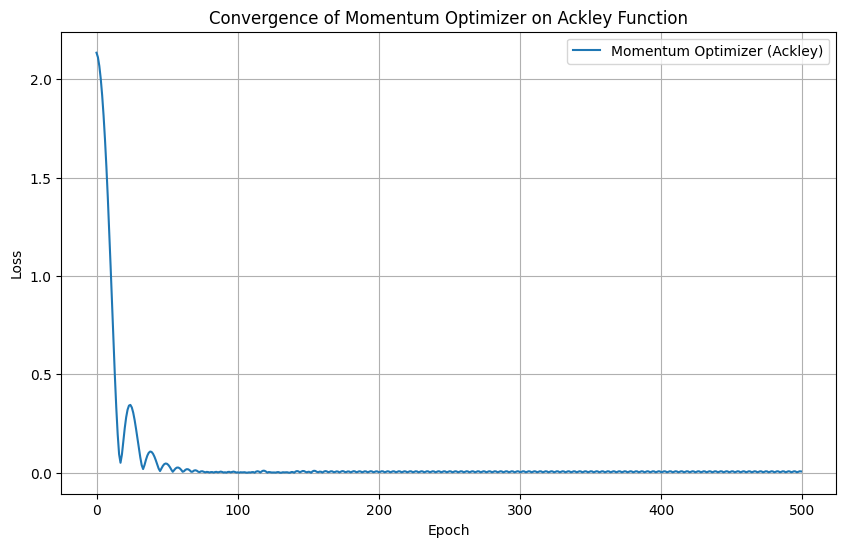


Final loss: 0.006652 (Expected: ~0)
Final weight values: [ 8.26930546e-04  6.25417592e-04  3.20781861e-04 -8.64602836e-04
 -7.43423251e-04  8.43294113e-04  2.40421465e-04 -8.75954677e-04
 -8.43259234e-04  3.69135128e-04 -8.70501151e-04 -7.44971672e-04
  1.10073894e-04  4.32825659e-04  3.43159351e-04 -6.16629966e-04
  4.78038006e-04 -5.88861214e-04 -3.94073899e-04  5.53620573e-04
  3.37914157e-04  7.63574128e-04  3.55885120e-04  1.54297415e-04
 -8.53413569e-04 -2.98796090e-04 -5.28020587e-04 -5.74307414e-04
  8.90094615e-04 -2.41490351e-04  8.34203554e-04  2.96211211e-04
  6.56709499e-04  5.95579127e-06  1.73717402e-04 -1.68985879e-05
 -6.77174038e-04  5.00805967e-04 -4.93670462e-04 -8.88847008e-04
  3.28538211e-04 -7.13544886e-04  8.85797100e-04  8.91491045e-04
  8.63502738e-04 -2.93283688e-04 -8.82565841e-04  8.76870203e-04
 -1.62221551e-04  8.91957520e-04] (Expected: Close to [0,0])
✅ Test Passed: Momentum optimizer correctly minimizes the Ackley function!

Testing with seed = 100


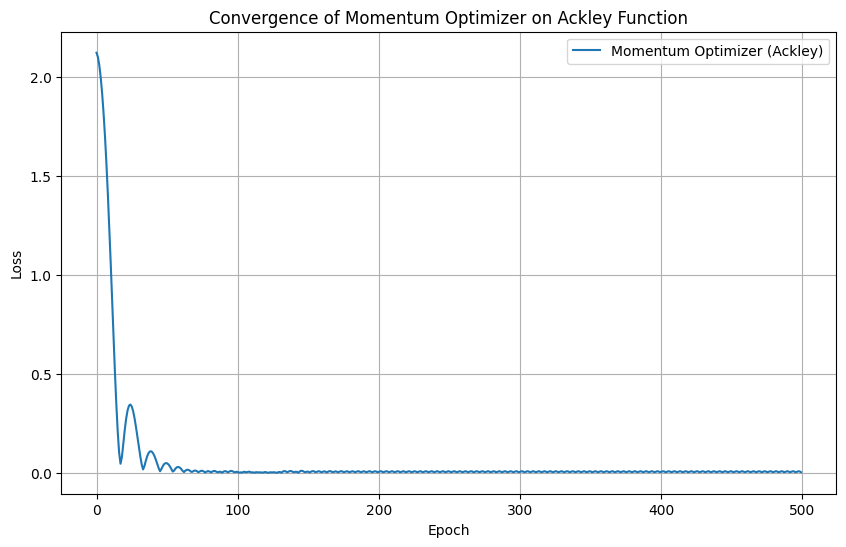


Final loss: 0.002514 (Expected: ~0)
Final weight values: [-1.94877508e-03 -1.74419408e-03 -4.73652991e-05  5.78685715e-04
  7.04424452e-04 -6.40035173e-04 -2.01830270e-04 -4.40591767e-04
 -3.93859033e-04  7.08995187e-04 -3.60217715e-04 -8.93182228e-06
  1.12372187e-04  1.17149436e-03 -7.10954721e-04 -2.49083783e-03
  2.03224530e-03 -3.79335941e-05 -1.70703777e-03  4.17650441e-04
 -7.14681751e-04  4.49137011e-04 -3.32052479e-04  4.33571199e-04
 -4.96044044e-04  2.64043319e-04 -3.55724332e-05 -6.92264161e-04
 -6.99985020e-04  2.08309545e-04  9.22505085e-04  5.89316544e-04
  5.03648233e-04 -1.76895221e-03  6.97567704e-04 -5.83435058e-05
 -7.26529122e-05 -2.09864738e-03 -5.43684451e-04 -4.16842980e-04
 -2.82267090e-03  2.24264826e-03  7.12817010e-04  2.34093266e-03
 -6.89886024e-04  1.10036129e-03  1.38096961e-03  4.15296855e-04
 -2.64406347e-04  5.64266003e-04] (Expected: Close to [0,0])
✅ Test Passed: Momentum optimizer correctly minimizes the Ackley function!

Testing with seed = 1710


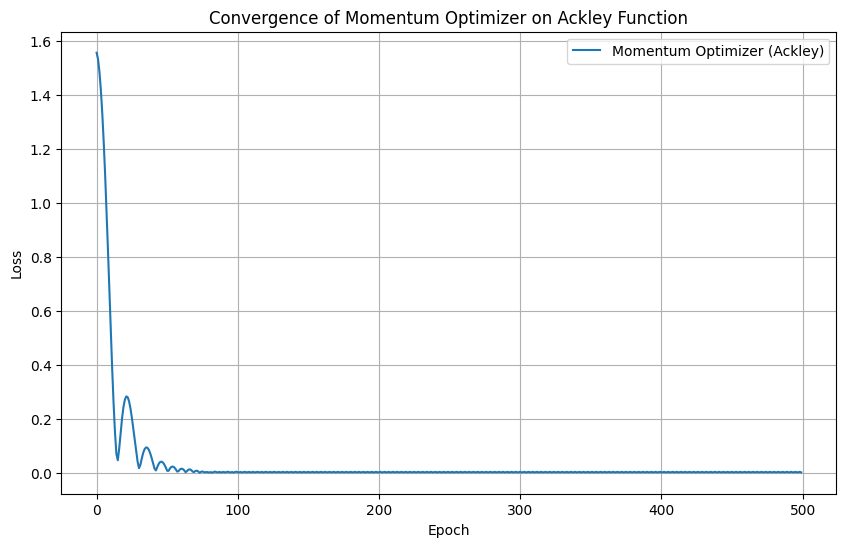


Final loss: 0.002208 (Expected: ~0)
Final weight values: [ 5.43315872e-04  2.10799075e-04 -6.46022448e-04  4.87077020e-04
  4.29819482e-04 -5.57091365e-04  1.33254750e-04  6.77195931e-04
 -5.84580075e-04  2.31371652e-04 -1.21308840e-03  6.27456924e-05
 -1.05411025e-04  1.17146198e-03 -6.90390824e-04  5.35844562e-04
  4.50831292e-05 -1.24809446e-03  5.12116716e-04 -1.57674116e-04
  2.79165378e-04 -1.24988148e-03  4.05756245e-04 -6.99368936e-04
  3.79351180e-04 -6.88677710e-04  1.04400814e-03  4.12769078e-04
  1.18708228e-03  7.50543371e-04 -1.02933181e-03  3.69680113e-04
 -9.34238310e-04  4.31439521e-04  5.80236838e-04  8.79624185e-04
  8.25908152e-04 -1.04781323e-03 -1.01494468e-03  8.86536965e-05
 -2.69743255e-04 -1.25064705e-03  1.05735236e-03 -7.76795362e-04
 -3.57361755e-04 -1.04068646e-03 -8.23530383e-04  8.70066474e-04
 -6.00953828e-04 -5.06333169e-04] (Expected: Close to [0,0])
✅ Test Passed: Momentum optimizer correctly minimizes the Ackley function!

Testing with seed = 1806


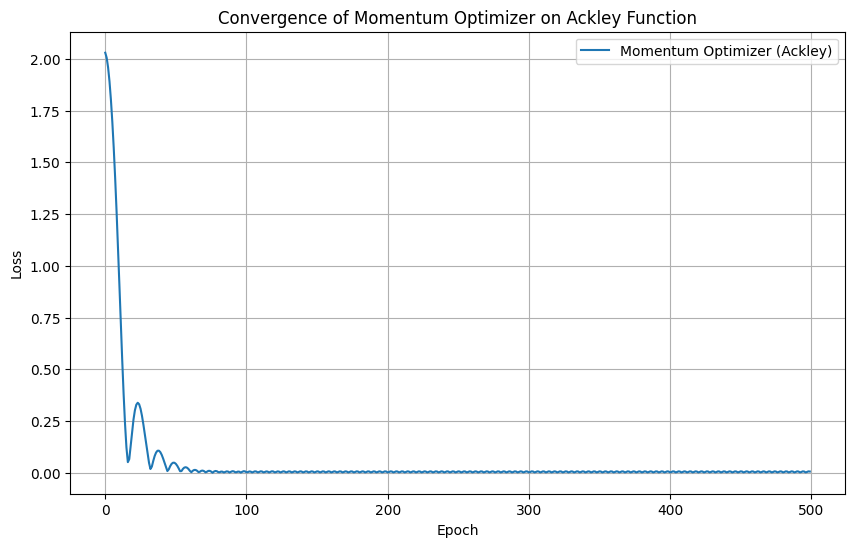


Final loss: 0.006652 (Expected: ~0)
Final weight values: [-5.53365021e-04 -5.01492139e-04 -6.65874043e-04 -4.74744073e-04
  2.16026369e-05  5.38783353e-04 -1.43106578e-04  3.30375456e-04
 -5.70671144e-04  6.91971766e-04 -8.58184316e-04 -5.33647414e-04
 -7.04120187e-04  7.81409023e-04  5.59048805e-04 -4.55519949e-04
 -2.00016303e-04  7.22848482e-04 -5.14314656e-04 -1.46169427e-04
 -4.79075968e-06 -5.60146048e-07 -7.93611541e-04 -2.01635749e-05
  3.38692524e-04 -8.14895349e-04 -6.97042012e-04 -4.89127573e-04
  7.59043454e-04  5.80752131e-04  1.08445775e-04 -8.80829305e-04
 -3.15495342e-04  7.10040971e-04  5.78887541e-04  3.17697580e-04
  8.07806932e-04  8.18543047e-04  2.79734873e-05  6.88046289e-05
 -8.80871408e-04  6.45986003e-04 -7.81988709e-04 -8.40219369e-04
  8.17776688e-04  1.08388975e-03 -8.14306499e-04  9.27035876e-04
 -8.74070449e-04 -7.92870254e-04] (Expected: Close to [0,0])
✅ Test Passed: Momentum optimizer correctly minimizes the Ackley function!


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Ackley function for testing
def ackley(x):
    """
    Computes the Ackley function in N-dimensional space.
    Global minimum: f(0,0,...) = 0.
    """
    a, b, c = 20, 0.2, 2 * np.pi
    n = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(np.cos(c * x))

    term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
    term2 = -np.exp(sum2 / n)

    return term1 + term2 + a + np.e

# Gradient of Ackley function
def ackley_grad(x):
    """
    Computes the gradient of the Ackley function for optimization.
    """
    a, b, c = 20, 0.2, 2 * np.pi
    n = len(x)
    term1 = (b / np.sqrt(n * np.sum(x**2))) * x * a * np.exp(-b * np.sqrt(np.sum(x**2) / n))
    term2 = (c / n) * np.sin(c * x) * np.exp(np.sum(np.cos(c * x)) / n)

    return term1 + term2

# Define a test subclass of ELM that overrides the loss function with Ackley
class ELM_Ackley(ELM):
    def __init__(self, input_size, hidden_size, output_size, seed=None):
        super().__init__(input_size, hidden_size, output_size, activation='relu', seed=seed)

    def evaluate_loss(self, X, y=None):
        """
        Override the loss function with Ackley.
        Instead of comparing to y, just evaluate Ackley on the weights.
        """
        return ackley(self.weights_hidden_output.flatten())

    def backward(self, X, y=None):
        """
        Compute gradients using the Ackley gradient function.
        """
        grad = ackley_grad(self.weights_hidden_output.flatten()).reshape(self.weights_hidden_output.shape)
        return grad, np.zeros_like(self.bias_output)  # No gradient for bias

# Test function to check correctness
def test_elm_momentum_correctness(elm, input_size, output_size):
    X_train = np.zeros((10, input_size))
    y_train = np.zeros((10, output_size))
    X_val, y_val = X_train, y_train

    # Use lower learning rate and momentum
    epochs = 500
    lr = 0.01
    momentum_coef = 0.9

    train_loss_history, _ = train_momentum(elm, X_train, y_train, X_val, y_val, epochs, lr, momentum_coef)

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label="Momentum Optimizer (Ackley)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Convergence of Momentum Optimizer on Ackley Function")
    plt.legend()
    plt.grid()
    plt.show()

    final_loss = train_loss_history[-1]
    final_weights = elm.weights_hidden_output.flatten()

    print(f"\nFinal loss: {final_loss:.6f} (Expected: ~0)")
    print(f"Final weight values: {final_weights} (Expected: Close to [0,0])")

    # Final correctness check
    assert final_loss < 1e-2, "Test failed: Final loss is too high!"
    assert np.linalg.norm(final_weights) < 1e-2, "Test failed: Final weights are not near zero!"

    print("✅ Test Passed: Momentum optimizer correctly minimizes the Ackley function!")

# Run the test
for seed in [42, 100, 1710, 1806]:
      print(f"\nTesting with seed = {seed}")
      n_input = 2
      n_hidden = 50
      n_output = 1
      elm = ELM_Ackley(input_size=n_input, hidden_size=n_hidden, output_size=n_output, seed=seed)
      test_elm_momentum_correctness(elm, n_input, n_output)

### Experiments

Starting momentum-based experiments on Synthetic Data...
[Momentum] λ=0.0001, lr=0.005, momentum=0.8 => Train Loss: 562.7460, Val Loss: 587.1945, Sparsity: 0.00%, Total Time: 2.17s
[Momentum] λ=0.0001, lr=0.005, momentum=0.9 => Train Loss: 559.2908, Val Loss: 588.6160, Sparsity: 0.00%, Total Time: 1.52s
[Momentum] λ=0.0001, lr=0.01, momentum=0.8 => Train Loss: 559.2834, Val Loss: 588.6065, Sparsity: 0.00%, Total Time: 1.54s
[Momentum] λ=0.0001, lr=0.01, momentum=0.9 => Train Loss: 557.1924, Val Loss: 591.0906, Sparsity: 0.00%, Total Time: 1.53s
[Momentum] λ=0.0001, lr=0.02, momentum=0.8 => Train Loss: 557.2036, Val Loss: 591.0594, Sparsity: 0.00%, Total Time: 3.83s
[Momentum] λ=0.0001, lr=0.02, momentum=0.9 => Train Loss: 556.7594, Val Loss: 593.5421, Sparsity: 0.00%, Total Time: 1.61s
[Momentum] λ=0.01, lr=0.005, momentum=0.8 => Train Loss: 564.1962, Val Loss: 588.2049, Sparsity: 0.00%, Total Time: 1.60s
[Momentum] λ=0.01, lr=0.005, momentum=0.9 => Train Loss: 560.7255, Val Loss: 589.

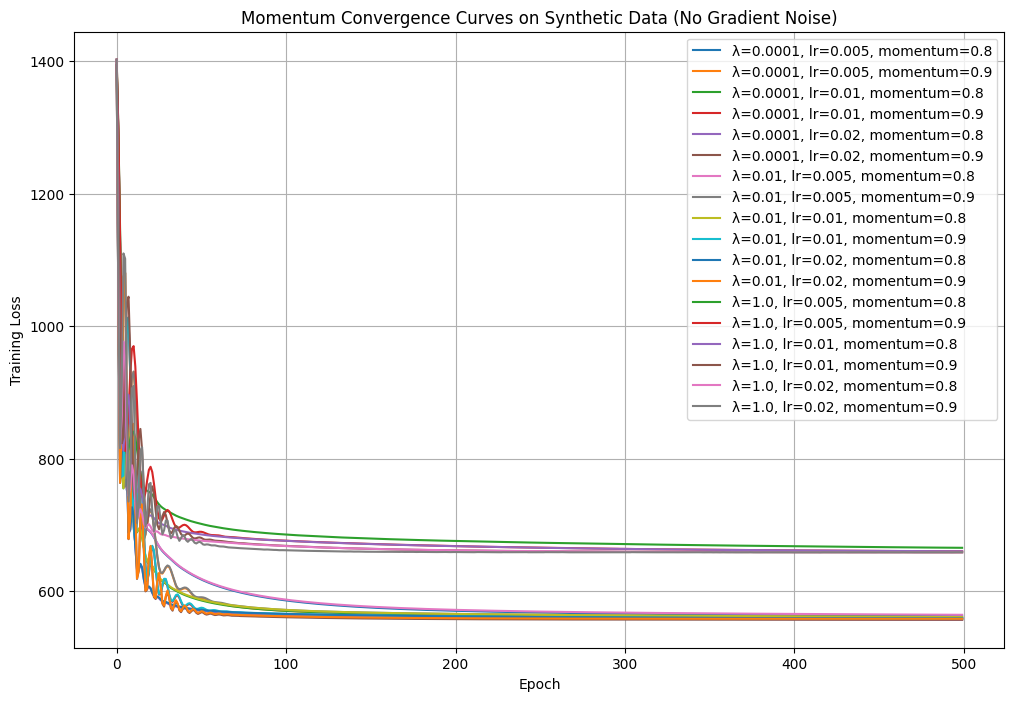


Summary of Experimental Results (Synthetic Data):
Algorithm	λ	lr	Momentum	Final Train Loss	Final Val Loss	Sparsity (%)	Total Time (s)	Avg Epoch Time (s)
momentum	1.0e-04	0.005	0.80		562.7460		587.1945		0.00		2.17		0.0043
momentum	1.0e-04	0.005	0.90		559.2908		588.6160		0.00		1.52		0.0030
momentum	1.0e-04	0.010	0.80		559.2834		588.6065		0.00		1.54		0.0031
momentum	1.0e-04	0.010	0.90		557.1924		591.0906		0.00		1.53		0.0031
momentum	1.0e-04	0.020	0.80		557.2036		591.0594		0.00		3.83		0.0077
momentum	1.0e-04	0.020	0.90		556.7594		593.5421		0.00		1.61		0.0032
momentum	1.0e-02	0.005	0.80		564.1962		588.2049		0.00		1.60		0.0032
momentum	1.0e-02	0.005	0.90		560.7255		589.6984		0.00		1.52		0.0030
momentum	1.0e-02	0.010	0.80		560.7186		589.6893		0.00		1.56		0.0031
momentum	1.0e-02	0.010	0.90		558.6203		592.1817		0.00		1.54		0.0031
momentum	1.0e-02	0.020	0.80		558.6316		592.1498		2.00		1.53		0.0031
momentum	1.0e-02	0.020	0.90		558.1935		594.6251		0.00		3.61		0.0072
momentum	1.0e+00	0.005	0.80		6

In [26]:
# =============================================================================
# Experiment Evaluation Function for Momentum Approach
# =============================================================================
def evaluate_experiments_momentum(X_train, y_train, X_val, y_val,
                                  input_size, hidden_size, output_size,
                                  epochs, seed):
    """
    Run experiments over a grid of hyperparameters for the momentum approach.

    We vary:
      - Learning rate (lr)
      - Momentum coefficient (eta)
      - Regularization parameter lambda (l1_lambda)
      - Gradient noise levels

    Metrics collected include:
      - Convergence speed (loss curves)
      - Final loss values (train and validation)
      - Sparsity of W2 (fraction of weights with abs(value) < threshold)
      - Computational efficiency (total training time and avg epoch time)
      - Robustness (performance variation under different noise levels)
    """
    learning_rates = [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    momentum_coefs = [0.1, 0.3, 0.5, 0.8, 0.9, 0.99, 0.999]
    lambda_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]  # test different L1 regularization strengths

    results = {}

    for lam, lr, momentum in itertools.product(lambda_values, learning_rates, momentum_coefs):
        # Initialize the model (same architecture, fixed seed for reproducibility)
        elm_model = ELM(input_size, hidden_size, output_size, activation='relu', seed=seed)
        elm_model.l1_lambda = lam

        start_time = time.time()
        train_losses, val_losses = train_momentum(elm_model, X_train, y_train, X_val, y_val,
                                                    epochs, lr, momentum)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs

        # Compute sparsity of W2: fraction of weights with abs(value) below a small threshold.
        threshold = 1e-3
        sparsity = np.mean(np.abs(elm_model.weights_hidden_output) < threshold)

        config = ('momentum', lam, lr, momentum)
        results[config] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "total_time": total_time,
            "avg_epoch_time": avg_epoch_time,
            "final_sparsity": sparsity,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1]
        }
        print(f"[Momentum] λ={lam}, lr={lr}, momentum={momentum} => "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Sparsity: {sparsity*100:.2f}%, Total Time: {total_time:.2f}s")

    return results

# --- Synthetic Data Experiment ---
input_size = 100      # number of input features
hidden_size = 100      # fixed hidden layer size
output_size = 1       # regression output
n_samples = 1000      # total samples
noise_std_data = 0.1  # noise level in data
seed = 42
epochs = 500        # number of training epochs

X_syn, y_syn = generate_synthetic_data(n_samples, input_size, hidden_size, output_size,
                                        noise_std=noise_std_data, seed=seed)
split_index = int(0.8 * n_samples)
X_train_syn, y_train_syn = X_syn[:split_index], y_syn[:split_index]
X_val_syn, y_val_syn = X_syn[split_index:], y_syn[split_index:]

print("Starting momentum-based experiments on Synthetic Data...")
results_synthetic = evaluate_experiments_momentum(X_train_syn, y_train_syn, X_val_syn, y_val_syn,
                                                  input_size, hidden_size, output_size,
                                                  epochs, seed)

# Plot convergence curves for a subset of experiments (e.g. no gradient noise) for clarity.
plt.figure(figsize=(12, 8))

for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    plt.plot(metrics["train_losses"], label=f"λ={lam}, lr={lr_val}, momentum={momentum}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Momentum Convergence Curves on Synthetic Data")
plt.legend()
plt.grid(True)
plt.show()

# Summary table of key metrics.
print("\nSummary of Experimental Results (Synthetic Data):")
header = ("Algorithm", "λ", "lr", "Momentum", "Final Train Loss",
          "Final Val Loss", "Sparsity (%)", "Total Time (s)", "Avg Epoch Time (s)")
print("\t".join(str(h) for h in header))
for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    print(f"{algo}\t{lam:.1e}\t{lr_val:.3f}\t{momentum:.2f}\t\t"
          f"{metrics['final_train_loss']:.4f}\t\t{metrics['final_val_loss']:.4f}\t\t"
          f"{metrics['final_sparsity']*100:.2f}\t\t{metrics['total_time']:.2f}\t\t"
          f"{metrics['avg_epoch_time']:.4f}")

# Print information at the end of the descent
# - final value
# - difference
# - convergence speed
print()

## California Housing dataset

Starting momentum-based experiments on California Housing Data...
[Momentum] λ=0.0001, lr=0.005, momentum=0.8 => Train Loss: 0.2886, Val Loss: 0.2997, Sparsity: 0.00%, Total Time: 10.21s
[Momentum] λ=0.0001, lr=0.005, momentum=0.9 => Train Loss: 0.2632, Val Loss: 0.2728, Sparsity: 2.00%, Total Time: 8.62s
[Momentum] λ=0.0001, lr=0.01, momentum=0.8 => Train Loss: 0.2631, Val Loss: 0.2727, Sparsity: 2.00%, Total Time: 7.10s
[Momentum] λ=0.0001, lr=0.01, momentum=0.9 => Train Loss: 0.2464, Val Loss: 0.2558, Sparsity: 2.00%, Total Time: 8.17s
[Momentum] λ=0.0001, lr=0.02, momentum=0.8 => Train Loss: 0.2464, Val Loss: 0.2558, Sparsity: 0.00%, Total Time: 7.36s
[Momentum] λ=0.0001, lr=0.02, momentum=0.9 => Train Loss: 0.2367, Val Loss: 0.2471, Sparsity: 0.00%, Total Time: 9.38s
[Momentum] λ=0.01, lr=0.005, momentum=0.8 => Train Loss: 0.3540, Val Loss: 0.3651, Sparsity: 16.00%, Total Time: 8.70s
[Momentum] λ=0.01, lr=0.005, momentum=0.9 => Train Loss: 0.3150, Val Loss: 0.3260, Sparsity: 18.00

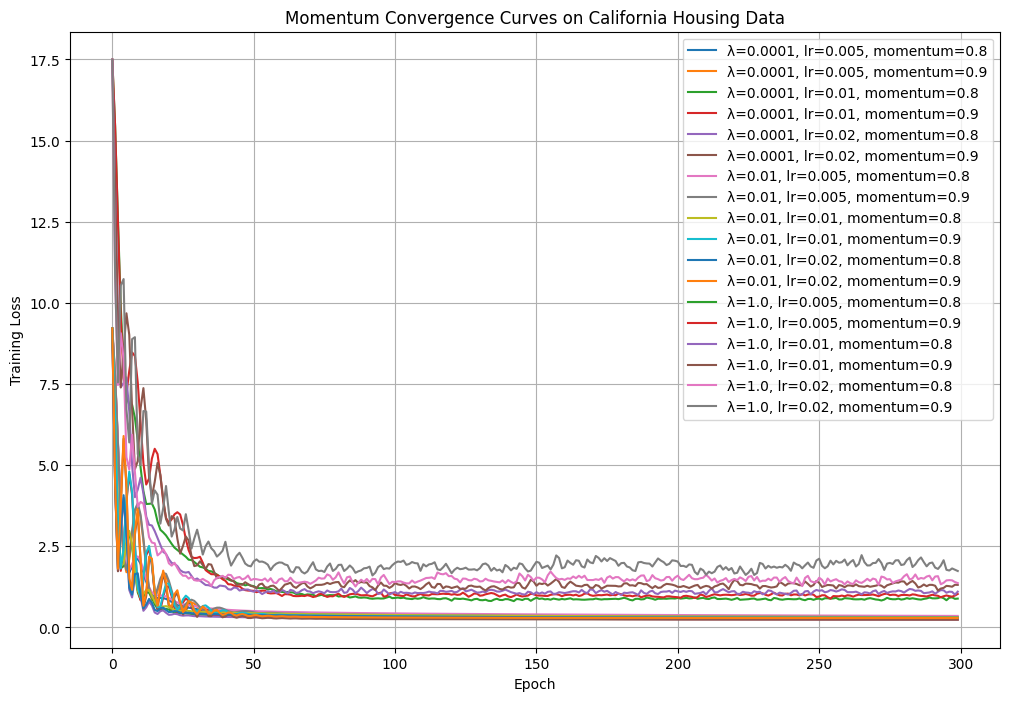


Summary of Experimental Results (California Housing):
Algorithm	λ	lr	Momentum	Final Train Loss	Final Val Loss	Sparsity (%)	Total Time (s)	Avg Epoch Time (s)
momentum	1.0e-04	0.005	0.80		0.2886		0.2997		0.00		10.21		0.0340
momentum	1.0e-04	0.005	0.90		0.2632		0.2728		2.00		8.62		0.0287
momentum	1.0e-04	0.010	0.80		0.2631		0.2727		2.00		7.10		0.0237
momentum	1.0e-04	0.010	0.90		0.2464		0.2558		2.00		8.17		0.0272
momentum	1.0e-04	0.020	0.80		0.2464		0.2558		0.00		7.36		0.0245
momentum	1.0e-04	0.020	0.90		0.2367		0.2471		0.00		9.38		0.0313
momentum	1.0e-02	0.005	0.80		0.3540		0.3651		16.00		8.70		0.0290
momentum	1.0e-02	0.005	0.90		0.3150		0.3260		18.00		7.31		0.0244
momentum	1.0e-02	0.010	0.80		0.3147		0.3258		18.00		8.52		0.0284
momentum	1.0e-02	0.010	0.90		0.2948		0.3067		28.00		8.01		0.0267
momentum	1.0e-02	0.020	0.80		0.2949		0.3067		30.00		8.13		0.0271
momentum	1.0e-02	0.020	0.90		0.2898		0.3022		44.00		8.83		0.0294
momentum	1.0e+00	0.005	0.80		0.8876		0.8476		10.00		7.19		0.0240
mo

In [28]:
# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_california_housing_data(test_size=0.2, random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Set input_size as number of features, and output_size = 1.
    input_size = X.shape[1]
    hidden_size = 50  # fixed hidden layer size for the experiment
    output_size = 1
    return X_train, y_train, X_val, y_val, input_size, hidden_size, output_size

# Load and preprocess California Housing data.
X_train_ch, y_train_ch, X_val_ch, y_val_ch, input_size_ch, hidden_size_ch, output_size_ch = load_california_housing_data(test_size=0.2, random_state=42)

# Choose an appropriate number of epochs for this dataset.
epochs_ch = 300
seed = 42

print("Starting momentum-based experiments on California Housing Data...")
results_california = evaluate_experiments_momentum(X_train_ch, y_train_ch, X_val_ch, y_val_ch,
                                                   input_size_ch, hidden_size_ch, output_size_ch,
                                                   epochs_ch, seed)

# Plot convergence curves for experiments without gradient noise.
plt.figure(figsize=(12, 8))
for config, metrics in results_california.items():
    algo, lam, lr_val, momentum = config
    plt.plot(metrics["train_losses"], label=f"λ={lam}, lr={lr_val}, momentum={momentum}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Momentum Convergence Curves on California Housing Data")
plt.legend()
plt.grid(True)
plt.show()

# Print a summary table of key metrics.
print("\nSummary of Experimental Results (California Housing):")
header = ("Algorithm", "λ", "lr", "Momentum", "Final Train Loss",
          "Final Val Loss", "Sparsity (%)", "Total Time (s)", "Avg Epoch Time (s)")
print("\t".join(str(h) for h in header))
for config, metrics in results_california.items():
    algo, lam, lr_val, momentum = config
    print(f"{algo}\t{lam:.1e}\t{lr_val:.3f}\t{momentum:.2f}\t\t"
          f"{metrics['final_train_loss']:.4f}\t\t{metrics['final_val_loss']:.4f}\t\t"
          f"{metrics['final_sparsity']*100:.2f}\t\t{metrics['total_time']:.2f}\t\t"
          f"{metrics['avg_epoch_time']:.4f}")